# ASSIGNMENT 2: MovieLens Dataset.

The dataset describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. In this project we use standard (latest) version of the MovieLens dataset. As in the previous assignmnet we will analyzie and explore the data, then we will pre-process the data and build a rule based and clustering based recommender system. Our steps:

1. Analyzing and Exploring the data.
2. Pre-processing.
3. Rule based system.
4. Clustering.


### 01. Analyzing the data - movie lens dataset.

##### step 1: information about number of movies and number of users


In [34]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [27]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [28]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [29]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975


##### step 2: distribution of movie ratings

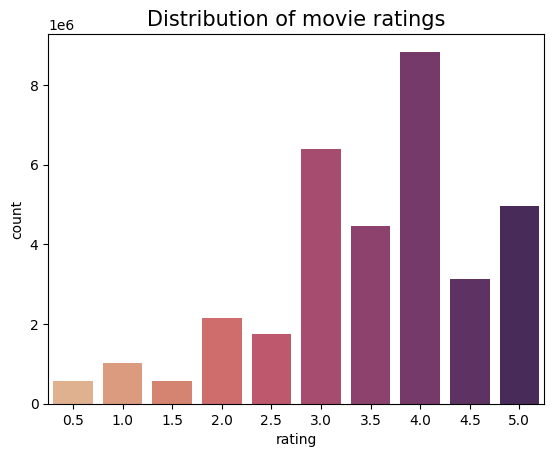

In [31]:
sns.countplot(x="rating", data = ratings, palette = "flare", hue="rating",legend=False)
plt.title("Distribution of movie ratings", fontsize = 15)
plt.show()

##### step 3: most frequently rated movies

In [32]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)                         122296
Forrest Gump (1994)                                      113581
Pulp Fiction (1994)                                      108756
Matrix, The (1999)                                       107056
Silence of the Lambs, The (1991)                         101802
Star Wars: Episode IV - A New Hope (1977)                 97202
Fight Club (1999)                                         86207
Schindler's List (1993)                                   84232
Jurassic Park (1993)                                      83026
Star Wars: Episode V - The Empire Strikes Back (1980)     80200
Name: count, dtype: int64

##### step 4: cleaning dataset: 
- _genres_ is expressed as a string with a pipe | separating each genre. We want to delete this pipe - we will create a list instead.
- _title_ we cannot extract year of the movie from the title, because some names of the movie repeat.

In [33]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [36]:
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'Adventure': 5349,
         'Animation': 4579,
         'Children': 4367,
         'Comedy': 22830,
         'Fantasy': 3821,
         'Romance': 10172,
         'Drama': 33681,
         'Action': 9563,
         'Crime': 6917,
         'Thriller': 11675,
         'Horror': 8570,
         'Mystery': 3972,
         'Sci-Fi': 4850,
         'IMAX': 195,
         'Documentary': 9283,
         'War': 2301,
         'Musical': 1059,
         'Western': 1690,
         'Film-Noir': 354,
         '(no genres listed)': 7060})